# Image Processing with Python: Image Segmentation using Thresholding Methods

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How to pinpoint and segment objects based on their color channels?

In this post, we will explore how to conduct image segmentation using trial and error thresholding and Otsu’s method. Moreover, we will explore how the RGB and HSV color spaces can be useful in segmenting images.

Let’s begin.

As usual, we import libraries such as numpy and matplotlib. Additionally, we import specific functions from the skimage library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.exposure import histogram
from skimage.filters import threshold_otsu

Let's use this image of a *Chico* tree with some of its fruits. 

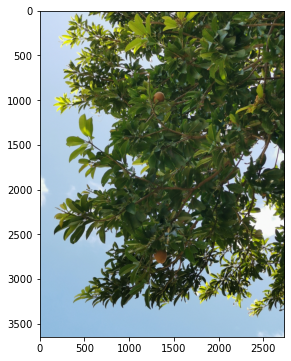

In [2]:
plt.figure(figsize=(6,6))
chico = imread('chico.jpg')
plt.imshow(chico);

We have previously discussed how binarizing an image can be useful since it simplifies the analysis when the pixel values are constrained only to 0s and 1s. So far, we have been using trial and error to find the arbitrary threshold value that best captures our desired shape of the objects.

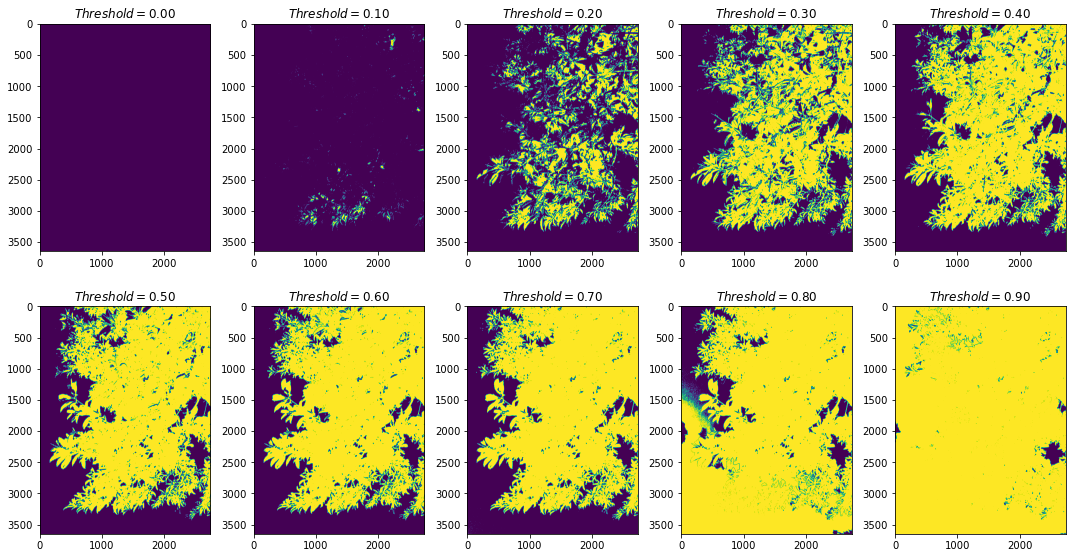

In [3]:
th_values = np.linspace(0, 1, 11)
fig, axis = plt.subplots(2, 5, figsize=(15,8))

chico_gray = rgb2gray(chico)
for th, ax in zip(th_values, axis.flatten()):
    
    chico_binarized = chico_gray < th
    ax.imshow(chico_binarized)
    ax.set_title('$Threshold = %.2f$' % th)
plt.tight_layout()

From this image, we might choose a thresholding value of 0.40 to 0.60 since it captures most of the leaves in the tree. However, this method is **subjective**. Let’s see if we can automate determining the thresholding value by looking at the intensity values histogram.

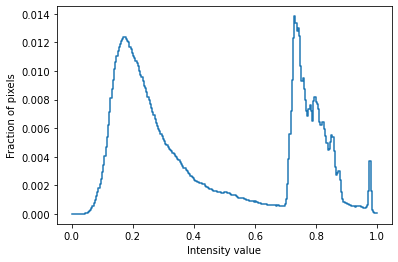

In [4]:
freq, bins = histogram(chico_gray)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('Intensity value')
plt.ylabel('Fraction of pixels');

From the histogram, we can see that there are two distributions in the image. This also explains why the optimal value in the trial and error method is in the range of 0.40 to 0.60 thresholding value. However, what if I told you that there is an automated way to determine this threshold value? This solution is called the Otsu’s method.

**Otsu’s method** assumes that the image is composed of a background and a foreground. This method works by minimizing the intra-class variance or maximizing the inter-class variance. Let’s see how this works.

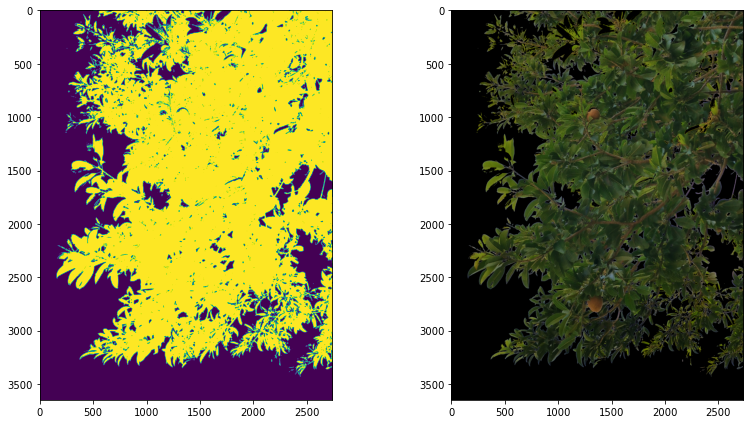

In [5]:
def masked_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])

fig, ax = plt.subplots(1, 2, figsize=(12,6))

thresh = threshold_otsu(chico_gray)
chico_otsu  = chico_gray < thresh
ax[0].imshow(chico_otsu)

filtered = masked_image(chico, chico_otsu)
ax[1].imshow(filtered)

plt.tight_layout()

Amazing, right? Now, we could bother less on determining the best threshold value in binarizing the image! However, we should ALWAYS remember this method’s underlying assumption: **the image is composed of a background and a foreground**. This means that if we take a look at the histogram, there should only be two separable distributions.

Now, dividing the background and the foreground can be really useful. However, most of our image segmentation problems is not a background-foreground problem. For example, we cannot simply use Otsu’s method in segmenting the Chico fruits from the leaves — this is because both are in the foreground of the image.

To address this problem, we should look at the color spaces of the images. As I have mentioned in my previous posts, any color is simply a combination of varying pixel intensity values in the image’s channels. Therefore, to segment a specific color in an image, we must use the thresholding method on the particular ratios of pixel intensity values in the three channels. Let’s try this in the RGB color space.

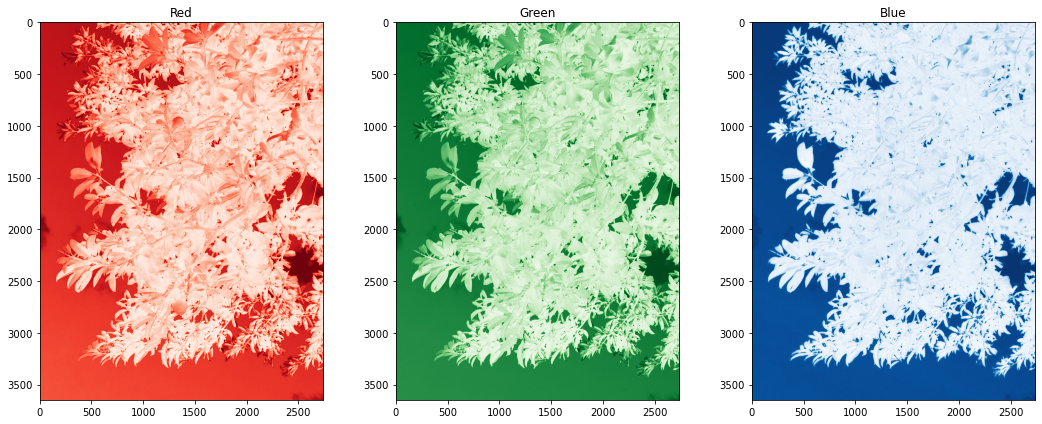

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].imshow(chico[:,:,0], cmap='Reds')
ax[0].set_title('Red')

ax[1].imshow(chico[:,:,1], cmap='Greens')
ax[1].set_title('Green')

ax[2].imshow(chico[:,:,2], cmap='Blues')
ax[2].set_title('Blue');

plt.tight_layout()

Notice how the background has a high-intensity value while the objects themselves have a low-intensity value in all of the channels. This is because the background is the sky — which technically is the source of light. Thus, it naturally has a higher intensity value. This makes segmenting the image to background-foreground easier. However, this also makes segmenting images in the foreground much more challenging because of the much tighter pixel intensity range.

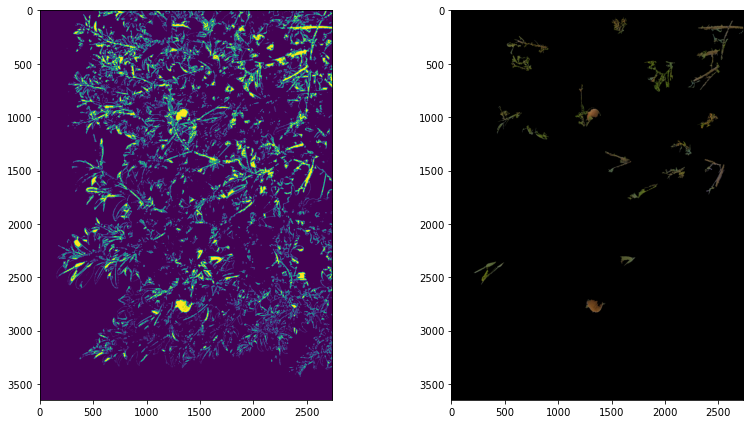

In [7]:
figure, ax = plt.subplots(1,2, figsize=(12,6))

chico_red = chico[:,:,0]
chico_green = chico[:,:,1]
chico_blue = chico[:,:,2]

binarized = ((chico_red < 200) & (chico_red > 75) & 
             (chico_green < 120) & (chico_green > 50) & 
             (chico_blue > 20))

opened = area_opening(binarized, 5000)
ax[0].imshow(binarized)
ax[1].imshow(masked_image(chico, opened))

plt.tight_layout()

Difficult, right? Even if we used area_opening to clean the image, it still does not show good results. Now, let’s try if we can make this easier by using the HSV color space.

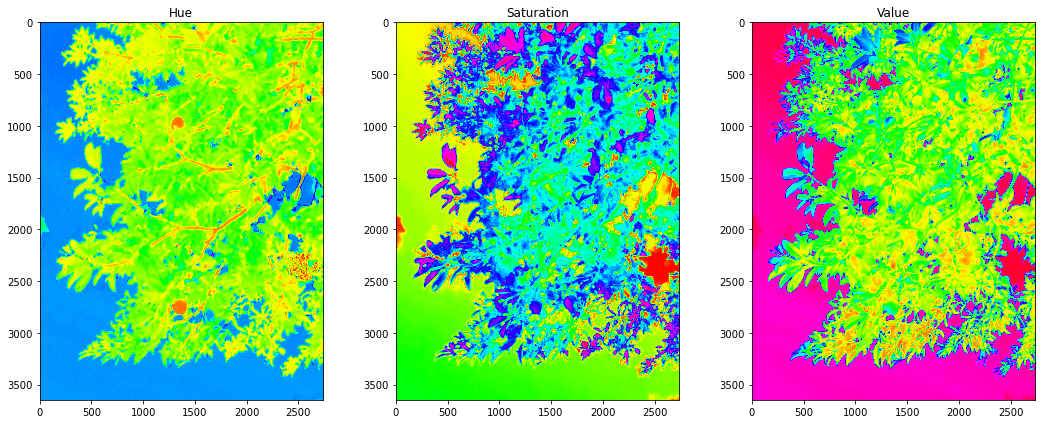

In [8]:
from skimage.color import rgb2hsv
chico_hsv = rgb2hsv(chico)

fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].imshow(chico_hsv[:,:,0], cmap='hsv')
ax[0].set_title('Hue')

ax[1].imshow(chico_hsv[:,:,1], cmap='hsv')
ax[1].set_title('Saturation')

ax[2].imshow(chico_hsv[:,:,2], cmap='hsv')
ax[2].set_title('Value');
plt.tight_layout()

Notice how the HSV color space can visualize the image’s objects much better than the RGB color space. Let’s try to use thresholding methods using this color space.

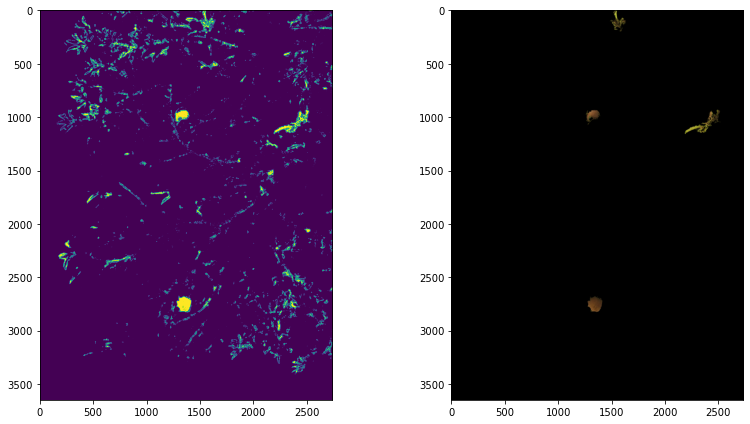

In [9]:
figure, ax = plt.subplots(1,2, figsize=(12,6))

chico_hue = chico_hsv[:,:,0] 
chico_sat = chico_hsv[:,:,1]
chico_val = chico_hsv[:,:,2]

binarized_hsv = ((chico_hue < 0.18) & (chico_hue > 0.05) & 
                 (chico_sat > 0.55)  & (chico_sat < 0.80))
opened = area_opening(binarized_hsv, 5000)
ax[0].imshow(binarized_hsv)
ax[1].imshow(masked_image(chico, opened))
plt.tight_layout()

See? Now, that’s easier! This can be attributed to the Hue channel of the HSV color space that clearly identifies the objects on the images based on 
their hue.

Ultimately, the choice of what color space should be used to segment the objects in the images is upon the discretion of the data scientist. I hope that by reading this post, you were able to get the intuition needed to implement your own image processing projects!

#### In summary

We have explored how to properly segment images to the background and foreground using the trial and error thresholding method and the Otsu’s Method. Moreover, we have also explored how the RGB and HSV color spaces can help pinpoint and segment objects in images.
